In [1]:
import pandas as pd
import ptitprince as pt
import numpy as np
import scipy.io
import scipy.stats as stats
import os
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy.matlib
import seaborn as sns
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.anova import AnovaRM

In [2]:
selected_subjects = range(8,27)
excluded_subjects = [13, 14]
selected_subjects = list(set(selected_subjects).symmetric_difference(excluded_subjects))
number_of_subjects = len(selected_subjects)

In [3]:
root_directory = '../data'
hemispheres = ['lh', 'rh']
regressors_of_interest = [
    'Stimulus_{Right,On}',
    'Stimulus_{Left,On}',
    'Stimulus_{Right,Off}',
    'Stimulus_{Left,Off}'
];

In [4]:
def make_figure(region):
    results = pd.DataFrame(columns=['Activation', 'Subject', 'Stimulus', 'Attention', 'Hemisphere', 'Area'])

    betas = {}
    betas['rh'] = np.zeros((number_of_subjects, len(regressors_of_interest)))
    betas['lh'] = np.zeros((number_of_subjects, len(regressors_of_interest)))
    for subject in range(len(selected_subjects)):
        for hemisphere in hemispheres:
            design_matrix = np.empty((0,0))
            regressors = []
            time_course = []
            for chunk in range(1,4):
                subject_directory = '{:s}/SubjectData/Subject{:02d}/Set{:d}'.format(
                    root_directory, selected_subjects[subject], chunk
                )
                design_file = '{:s}/DesignMatrix/DesignStimulus.mat'.format(subject_directory);
                if not os.path.isfile(design_file):
                    continue

                mat = scipy.io.loadmat(design_file)
                d = mat['design']['DesignMatrix'][0,0]
                r = mat['design']['RegressorLabel'][0,0]
                design_matrix = np.concatenate((
                    np.concatenate((design_matrix, np.zeros((d.shape[0], design_matrix.shape[1]))), axis=0),
                    np.concatenate((np.zeros((design_matrix.shape[0], d.shape[1])), d), axis=0)),
                axis=1)
                regressors += [i[0][0] for i in np.transpose(r)]
                design_matrix = pd.DataFrame(data=design_matrix, columns=regressors)

                timecourse_file ='{:s}/TimeCourses/{:s}.{:s}.mat'.format(
                    subject_directory, hemisphere, region
                )
                mat = scipy.io.loadmat(timecourse_file)
                time_course += [i[0] for i in mat['timeCourses']]

            time_course = np.concatenate((time_course), axis=1)
            model = LinearRegression(fit_intercept=False)
            model.fit(design_matrix, np.transpose(time_course))
            b = pd.DataFrame(model.coef_, columns=regressors)

            for regressor in range(len(regressors_of_interest)): 
                percent_signal_change = np.divide(b[regressors_of_interest[regressor]], b['Constant'])
                mean_over_runs = np.mean(percent_signal_change, 1)[0]
                betas[hemisphere][subject,regressor] += mean_over_runs


                if regressor == 0: # 'Stimulus_{Right,On}':
                    stimulus = 'On'
                    if hemisphere == 'lh':
                        attention = 'On'
                    else:
                        attention = 'Off'
                elif regressor == 1: # 'Stimulus_{Left,On}':
                    stimulus = 'On'
                    if hemisphere == 'lh':
                        attention = 'Off'
                    else:
                        attention = 'On'
                elif regressor == 2: #'Stimulus_{Right,Off}':
                    stimulus = 'Off'
                    if hemisphere == 'lh':
                        attention = 'On'
                    else:
                        attention = 'Off'
                elif regressor == 3: #'Stimulus_{Left,Off}':
                    stimulus = 'Off'
                    if hemisphere == 'lh':
                        attention = 'Off'
                    else:
                        attention = 'On'
                
                results = results.append({'Activation': betas[hemisphere][subject,regressor], 'Subject': subject, 'Stimulus': stimulus, 'Attention': attention, 'Hemisphere': hemisphere, 'Area': region}, ignore_index=True)
        
    return results

def color_significant_values(value):
    if value > 0.05:
        color = "black"
    elif value > 0.01:
        color = 'darkred'
    else:
        color = 'green'
    return 'color: %s' % color

def bold_face(value):
    return 'font-weight: bold'

In [5]:
regions = ['V1', 'V2', 'V3']

group_results = pd.DataFrame()
betas = pd.DataFrame(columns=['Activation', 'Subject', 'Stimulus', 'Attention', 'Hemisphere', 'Area'])
for region in regions:
    a = make_figure(region)
    betas = betas.append(a)

aov_table = AnovaRM(betas, 'Activation', 'Subject', within=['Stimulus', 'Attention', 'Hemisphere', 'Area'])
res = aov_table.fit()

pd.DataFrame(res.summary().tables[0]) \
    .style \
    .applymap(color_significant_values, subset=['Pr > F']) \
    .format({'F Value': "{:.3f}", 'Num DF': "{:.0f}", 'Den DF': "{:.0f}", 'Pr > F': "{:.4e}"})

<ipython-input-4-467698c95392>:42: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  percent_signal_change = np.divide(b[regressors_of_interest[regressor]], b['Constant'])
<ipython-input-4-467698c95392>:42: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'u

<ipython-input-4-467698c95392>:42: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  percent_signal_change = np.divide(b[regressors_of_interest[regressor]], b['Constant'])
<ipython-input-4-467698c95392>:42: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'u

<ipython-input-4-467698c95392>:42: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  percent_signal_change = np.divide(b[regressors_of_interest[regressor]], b['Constant'])
<ipython-input-4-467698c95392>:42: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'u

<ipython-input-4-467698c95392>:42: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  percent_signal_change = np.divide(b[regressors_of_interest[regressor]], b['Constant'])
<ipython-input-4-467698c95392>:42: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'u

<ipython-input-4-467698c95392>:42: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  percent_signal_change = np.divide(b[regressors_of_interest[regressor]], b['Constant'])
<ipython-input-4-467698c95392>:42: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'u

<ipython-input-4-467698c95392>:42: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  percent_signal_change = np.divide(b[regressors_of_interest[regressor]], b['Constant'])
<ipython-input-4-467698c95392>:42: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'u

<ipython-input-4-467698c95392>:42: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  percent_signal_change = np.divide(b[regressors_of_interest[regressor]], b['Constant'])
<ipython-input-4-467698c95392>:42: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'u

<ipython-input-4-467698c95392>:42: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  percent_signal_change = np.divide(b[regressors_of_interest[regressor]], b['Constant'])
<ipython-input-4-467698c95392>:42: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'u

,F Value,Num DF,Den DF,Pr > F
Stimulus,335.583,1,16,3.6881e-12
Attention,121.270,1,16,7.0670e-09
Hemisphere,0.088,1,16,7.7023e-01
Area,35.938,2,32,6.5792e-09
Stimulus:Attention,6.630,1,16,2.0350e-02
Stimulus:Hemisphere,4.475,1,16,5.0420e-02
Attention:Hemisphere,0.669,1,16,4.2542e-01
Stimulus:Area,41.218,2,32,1.3978e-09
Attention:Area,0.738,2,32,4.8593e-01
Hemisphere:Area,1.009,2,32,3.7594e-01


In [6]:
betas["Task"] = betas["Stimulus"] + betas["Attention"]
# group by everything but hemisphere and take the the mean over that dimension
betas = betas.groupby(['Subject', 'Stimulus', 'Attention', 'Task', 'Area']).mean().reset_index()

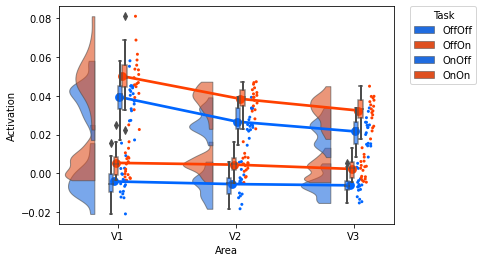

In [7]:
color_palletes = ["#0066ff", "#ff4000", "#0066ff", "#ff4000"]
dx   = "Area"
dy   = "Activation"
dhue = "Task"
pal  = sns.color_palette(color_palletes)

plt.figure()
ax = pt.RainCloud(
    data       = betas, 
    x          = dx, 
    y          = dy,
    hue        = dhue, 
    palette    = pal, 
    bw         = .4, 
    width_viol = .5,
    orient     = 'v' , 
    alpha      = .6, 
    dodge      = True, 
    pointplot  = True, 
    move       = 0.1    
)

plt.savefig(f'./img/region_stats.png', bbox_inches='tight')
plt.savefig(f'./img/region_stats.pdf', bbox_inches='tight')

In [8]:
task_effects = betas.groupby(['Task', 'Subject']).mean()
ttest_result = stats.ttest_rel(task_effects.query("Task == 'OffOn'")['Activation'], 
                       task_effects.query("Task == 'OffOff'")['Activation'])
effect_size = task_effects.query("Task == 'OffOn'")['Activation'].mean()- task_effects.query("Task == 'OffOff'")['Activation'].mean()

print("T-value: {:.3f}, p-value: {:.3e}, effect size: {:.2f}%".format(ttest_result[0],ttest_result[1] , effect_size * 100))

T-value: 9.799, p-value: 3.640e-08, effect size: 0.93%


### Negative attention effect for condition 'No stimulus, Unattended'

In [9]:
nostim_noatt_effect = betas.query(f"Task == 'OffOff'").groupby(['Subject']).mean()
ttest_result = stats.ttest_1samp(nostim_noatt_effect['Activation'], 0) 
effect_size = task_effects.query("Task == 'OffOff'")['Activation'].mean()

print("T-value: {:.3f}, p-value: {:.3e}, effect size: {:.2f}%".format(ttest_result[0],ttest_result[1] , effect_size * 100))

T-value: -3.122, p-value: 6.575e-03, effect size: -0.53%


### Effect sizes per region:

In [10]:
effects = pd.DataFrame(columns=['Region', 'Attention', 'Stimulus'])
for region in regions:

    att = betas.query(f"Area == '{region}'").groupby(['Subject', 'Attention']).mean().reset_index()
    att_effect = att.query(f"Attention == 'On'")["Activation"].reset_index() - att.query(f"Attention == 'Off'")["Activation"].reset_index()
    att_effect = att_effect.mean()[1]
    stim = betas.query(f"Area == '{region}'").groupby(['Subject','Stimulus']).mean().reset_index()
    stim_effect = stim.query(f"Stimulus == 'On'")["Activation"].reset_index()- stim.query(f"Stimulus == 'Off'")["Activation"].reset_index()
    stim_effect = stim_effect.mean()[1]
    effects.loc[len(effects)] = [region, att_effect, stim_effect]

effects.style.format('{:.2%}', subset=["Attention", "Stimulus"]) 


,Region,Attention,Stimulus
0,V1,1.01%,4.41%
1,V2,1.09%,3.30%
2,V3,0.96%,2.89%


In [11]:
ami = pd.DataFrame(columns=['Area', 'AMI', 'Subject'])
for region in regions:
    att = betas.query(f"Area == '{region}'").groupby(['Subject', 'Attention']).mean().reset_index()
    stim = betas.query(f"Area == '{region}'").groupby(['Subject','Stimulus']).mean().reset_index()
    att_effect = att.query(f"Attention == 'On'")["Activation"].values - att.query(f"Attention == 'Off'")["Activation"].values
    stim_effect = stim.query(f"Stimulus == 'On'")["Activation"].values - stim.query(f"Stimulus == 'Off'")["Activation"].values
    ami_scores = att_effect / (att_effect + stim_effect)
    for i in range(len(ami_scores)):
        ami = ami.append({'Area': region, 'AMI': ami_scores[i], 'Subject': i}, ignore_index=True)

In [12]:
ami.groupby(['Area']).mean()

,AMI
Area,
V1,0.182045
V2,0.243989
V3,0.245820


In [13]:
ami.groupby(['Area']).std()

,AMI
Area,
V1,0.048999
V2,0.071656
V3,0.092248


In [14]:
aov_table = AnovaRM(ami, 'AMI', 'Subject', within=['Area'])
res = aov_table.fit()
pd.DataFrame(res.summary().tables[0]) \
    .style \
    .applymap(color_significant_values, subset=['Pr > F']) \
    .format({'F Value': "{:.3f}", 'Num DF': "{:.0f}", 'Den DF': "{:.0f}", 'Pr > F': "{:.4e}"})

,F Value,Num DF,Den DF,Pr > F
Area,10.529,2,32,3.0656e-04


In [15]:
ami_diff = pd.DataFrame(columns=['Areas', 'tvalue', 'pvalue'])
test = stats.ttest_rel(ami.query("Area == 'V1'")['AMI'], ami.query("Area == 'V2'")['AMI'])
ami_diff.loc[len(ami_diff)] = {'Areas': 'V1-V2', 'tvalue': test.statistic, 'pvalue': test.pvalue}
test = stats.ttest_rel(ami.query("Area == 'V1'")['AMI'], ami.query("Area == 'V3'")['AMI'])
ami_diff.loc[len(ami_diff)] = {'Areas': 'V1-V3', 'tvalue': test.statistic, 'pvalue': test.pvalue}
test = stats.ttest_rel(ami.query("Area == 'V2'")['AMI'], ami.query("Area == 'V3'")['AMI'])
ami_diff.loc[len(ami_diff)] = {'Areas': 'V2-V3', 'tvalue': test.statistic, 'pvalue': test.pvalue}

ami_diff \
    .style \
    .applymap(color_significant_values, subset=['pvalue']) \
    .format({'pvalue': "{:.4e}"})

,Areas,tvalue,pvalue
0,V1-V2,-4.693548,2.4406e-04
1,V1-V3,-3.173822,5.8930e-03
2,V2-V3,-0.139178,8.9105e-01
